In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm

import matplotlib.pyplot as plt

import os, sys
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import jax
import jax.numpy as jnp
from functools import partial
import emcee
jax.config.update("jax_enable_x64", True)

import saqqara
import sys
sys.path.insert(0, '../inference/')
sys.path.insert(0, '../simulator/')
from networks import SignalAET
from simulator import LISA_AET
from dataloader import get_datasets, setup_dataloaders, get_data_npy_dataset, get_resampling_dataloader
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import pickle
import swyft
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [13]:
id = "G7RG"
config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
settings = saqqara.load_settings(config_path=config)
sim = LISA_AET(settings)
network = SignalAET(settings=settings, sim=sim)
network = saqqara.load_state(network=network, ckpt=ckpt)
trainer = saqqara.setup_trainer(settings, logger=None)

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


In [5]:
mcmc_sim = LISA_AET(settings=saqqara.load_settings(config_path="../configs/bounded_mcmc.yaml"))

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


In [6]:
class StatsModel:
    def __init__(self, simulator):
        self.sim = simulator
        self.Hubble_over_h = 3.24e-18
        self.Nbins = len(simulator.f_vec)
        self.TM_noise = jnp.abs(jnp.array(jnp.vstack([jnp.array(simulator.TM_tdi_matrix)[:, channel, channel] for channel in range(3)]).T / simulator.response_AET))
        self.OMS_noise = jnp.abs(jnp.array(jnp.vstack([jnp.array(simulator.OMS_tdi_matrix)[:, channel, channel] for channel in range(3)]).T / simulator.response_AET))
        self.f_vec = jnp.array(simulator.f_vec)

    def get_sample(self):
        return self.sim.sample()
    
    def get_quad_data(self, sample):
        return jnp.abs(sample['full_quadratic_data_AET'] / self.sim.response_AET)
    
    @partial(jax.jit, static_argnums=(0,))
    def sgwb_template(self, z_sgwb):
        conversion = 4 * jnp.pi**2 * self.f_vec**3 / 3 / self.sim.Hubble_over_h**2
        return jnp.abs(jnp.array(
            self.sim.overall_rescaling
            * 10 ** z_sgwb[0]
            * (self.f_vec / jnp.sqrt(self.f_vec [0] * self.f_vec [-1])) ** z_sgwb[1]
            / conversion
        ))
    
    @partial(jax.jit, static_argnums=(0,))
    def get_variance(self, z):
        z_sgwb, z_noise = z[:2], z[-2:]
        return z_noise[0]**2 * self.TM_noise + z_noise[1]**2 * self.OMS_noise + self.sgwb_template(z_sgwb)[:, None]
    
    @partial(jax.jit, static_argnums=(0,))
    def logL(self, z, quadratic_data_over_response, N_segments=1, channels=[0, 1, 2]):
        variance = self.get_variance(z)
        logL_array = -(jnp.log(variance[:, channels]) + quadratic_data_over_response[:, channels] / (variance[:, channels]))
        return N_segments * jnp.sum(logL_array)

    def log_prior(self, z):
        if not np.all(np.logical_and(z > self.sim.prior.bounds[:, 0], z < self.sim.prior.bounds[:, 1])):
            return -jnp.inf
        return 0

    def log_posterior(self, z, data, N_segments=1, channels=[0, 1, 2]):
        if jnp.isinf(self.log_prior(z)):
            return -jnp.inf
        return self.logL(z, data, N_segments, channels) + self.log_prior(z)

def mcmc(stats, data, nwalkers=100, nsteps=1000, Nsegs=1, channels=[0, 1, 2]):
    ndim = 4
    p0 = stats.sim.prior.sample(nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, stats.log_posterior, args=[data, Nsegs, channels])
    sampler.run_mcmc(p0, nsteps, progress=True)
    return sampler

In [7]:
def get_grid(N=1000, a_low=-11.42961597442627, a_high=-10.696080207824707, g_low=-0.7066106200218201, g_high=1.0477334260940552):
    a_samples = np.linspace(a_low, a_high, N)
    g_samples = np.linspace(g_low, g_high, N)
    ag_samples = np.array(np.meshgrid(a_samples, g_samples)).T.reshape(-1, 2)
    A_samples = np.ones(N)
    P_samples = np.ones(N)
    AP_samples = np.array(np.meshgrid(A_samples, P_samples)).T.reshape(-1, 2)
    return swyft.Samples(z=np.float32(np.concatenate((ag_samples, AP_samples), axis=1)))

prior_samples = get_grid(N=2000)

In [8]:
stats = StatsModel(mcmc_sim)

In [9]:
data_sample = sim.sample(conditions={'z': np.array([-11.0, 0.0, 3.0, 15.0])})
mcmc_data = stats.get_quad_data(data_sample)
observation = swyft.Sample(data=data_sample["full_coarse_grained_data"])

In [10]:
stats_sampler = mcmc(stats, mcmc_data, nwalkers=100, nsteps=1000, channels=[0, 1, 2])

100%|██████████| 1000/1000 [18:06<00:00,  1.09s/it]


In [14]:
observation = swyft.Sample(data=sim.generate_coarse_grained_data_from_sum(data_sample["full_quadratic_data_AET"]))
logratios = trainer.infer(network, observation, prior_samples, batch_size=100000)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 40/40 [00:15<00:00,  2.59it/s]


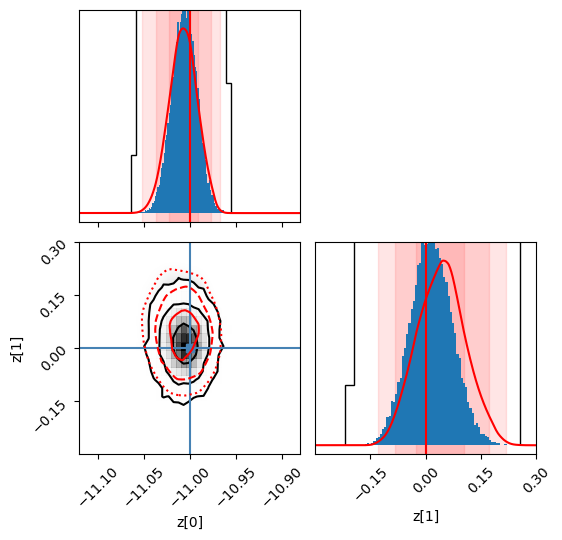

In [15]:
import corner
target_z = data_sample['z']
post_samples = stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, :2]
fig = corner.corner(
    post_samples,
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)]
)
colors = ["black", "red", "green"]
lims = [[-11.12, -10.88], [-0.3, 0.3]]
swyft.plot_corner(logratios, color='red', parnames=logratios.parnames[0], bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)], fig=plt.gcf())
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(data_sample['z'][j], c="r")
    plt.hist(stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [39]:
BASE_DIR = "../results/mcmc_comparison/"
pickle.dump(data_sample, open(BASE_DIR + "data_sample.pkl", "wb"))
pickle.dump(stats_sampler.get_chain(discard=100, thin=1, flat=True), open(BASE_DIR + "stats_chain.pkl", "wb"))
pickle.dump(logratios, open(BASE_DIR + "logratios.pkl", "wb"))
pickle.dump(sim.coarse_grained_f, open(BASE_DIR + "cg_f.pkl", "wb"))
pickle.dump(sim.response_AET, open(BASE_DIR + "response.pkl", "wb"))

In [35]:
logratios = pickle.load(open(BASE_DIR + "logratios.pkl", "rb"))

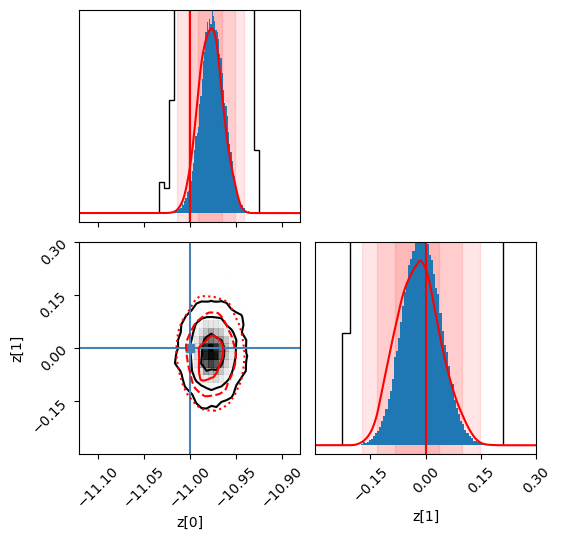

In [30]:
import corner
target_z = data_sample['z']
post_samples = stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, :2]
fig = corner.corner(
    post_samples,
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)]
)
colors = ["black", "red", "green"]
lims = [[-11.12, -10.88], [-0.3, 0.3]]
swyft.plot_corner(logratios, color='red', parnames=logratios.parnames[0], bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)], fig=plt.gcf())
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(data_sample['z'][j], c="r")
    plt.hist(stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])